In [116]:
import matplotlib.pyplot as plt #Biblioteca para plotar gráficos
import pandas as pd #Biblioteca de funções utilizada para manipular conjuntos de dados
import numpy as np #Biblioteca de funções matemáticas

Inicialmente utilizei a biblioteca Pandas para extrair a tabela com os dados referentes a série histórica do salário mínimo presente no seguinte link: https://previdenciarista.com/blog/tabela-historica-dos-salarios-minimos/. Para poder trabalhar com este conjunto de dados realizei algumas operações de limpeza de dados, como remover valores nulos e os símbolos R$ e % dos dados e trabalha-los como números decimais, por fim agrupei os anos que possuíam mais de um valor de salário pela média de salário daquele ano.

In [117]:
url = 'http://www.fetapergs.org.br/index.php/2015-07-27-16-46-22/tabelas-salario-minimo' #'https://previdenciarista.com/blog/tabela-historica-dos-salarios-minimos/'
sr_hist_sm = pd.read_html(url, header=[0])
df_sm = sr_hist_sm[0]
df_sm = df_sm[['Vigência','Salário Mínimo','Reajuste Salário Mínimo']]
df_sm['Ano'] = df_sm.Vigência.apply(lambda x: x[-4:])
df_sm = df_sm.drop(columns=['Vigência'])
df_sm = df_sm.rename(columns={'Salário Mínimo':'vl_sm','Reajuste Salário Mínimo':'vl_reaj_sm'})
df_sm = df_sm.dropna(subset=['vl_reaj_sm'])
df_sm['vl_sm'] = df_sm['vl_sm'].apply(lambda x: x.replace('R$ ','').replace('.','').replace(',','.'))
df_sm['vl_reaj_sm'] = df_sm['vl_reaj_sm'].apply(lambda x: x.replace('%','').replace(',','.'))
df_sm['vl_sm'] = df_sm['vl_sm'].astype(np.float64)
df_sm['vl_reaj_sm'] = df_sm['vl_reaj_sm'].astype(np.float64)
df_sm = df_sm.groupby('Ano').mean()

<ipython-input-117-3ae560dccc5f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sm['Ano'] = df_sm.Vigência.apply(lambda x: x[-4:])


Depois de tratar os dados referentes a série histórica do salário mínimo, trabalhei com o conjunto de dados extraído do site do Dieese https://www.dieese.org.br/cesta/ com filtros para o período de Janeiro de 2003 a Abril de 2022*. Nesse conjunto de dados também realizei algumas manipulações para extrair o ano e utiliza-lo para agrupar os dados.

*eu upei essa tabela para o google drive para poder consumir através do google colab

In [118]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTPD3e8JcLdGNZxefDYNTzqbz7SDrtUpdz4KqlTrBJLPbBjSN8Y8nhyFvebMvSRCAdwMW_l8INDKCGR/pubhtml'
cesta_basica = pd.read_html(url, header=[2],encoding='utf-8')
df_cb = pd.DataFrame(cesta_basica[0])
df_cb = df_cb.rename(columns={'Unnamed: 1':'Vigência','Aracaju':'vl_cb_aju','João Pessoa':'vl_cb_jpa','Recife':'vl_cb_rec'})
df_cb = df_cb.dropna(subset=['vl_cb_aju'])
df_cb['Ano'] = df_cb.Vigência.apply(lambda x: x[-4:])
df_cb = df_cb.drop(columns=['Vigência'])
df_cb = df_cb.groupby('Ano').mean()

A partir desses conjuntos de dados, combinei os dois dataframes em um só e inseri novas colunas com a razão entre o valor da cesta básica em cada cidade. 

In [119]:
df = pd.concat([df_sm,df_cb],axis=1)
df = df.dropna(subset=['vl_cb_aju'])
df = df.dropna(subset=['vl_sm'])
df['perc_sm_cb_aju'] = (df['vl_cb_aju']/df['vl_sm'])*100
df['perc_sm_cb_jpa'] = (df['vl_cb_jpa']/df['vl_sm'])*100
df['perc_sm_cb_rec'] = (df['vl_cb_rec']/df['vl_sm'])*100
df['perc_reaj_cb_aju'] = 0.0
df['perc_reaj_cb_jpa'] = 0.0
df['perc_reaj_cb_rec'] = 0.0

for i in range(1,len(df)):
    if df['vl_cb_aju'][i-1] != 0:
        df['perc_reaj_cb_aju'][i] = 100-float(df['vl_cb_aju'][i-1])/float(df['vl_cb_aju'][i])*100
        
for i in range(1,len(df)):
    if df['vl_cb_jpa'][i-1] != 0:
        df['perc_reaj_cb_jpa'][i] = 100-float(df['vl_cb_jpa'][i-1])/float(df['vl_cb_jpa'][i])*100
        
for i in range(1,len(df)):
    if df['vl_cb_rec'][i-1] != 0:
        df['perc_reaj_cb_rec'][i] = 100-float(df['vl_cb_rec'][i-1])/float(df['vl_cb_rec'][i])*100


Por fim utilizei os valores dessas novas colunas pra gerar um gráfico que representasse ao longo do tempo qual a porcentagem do salário mínimo dedicado a custear a cesta básica nas cidades analisadas.

Text(0.5, 1.0, 'Análise do período de Janeiro de 2003 e Abril de 2022')

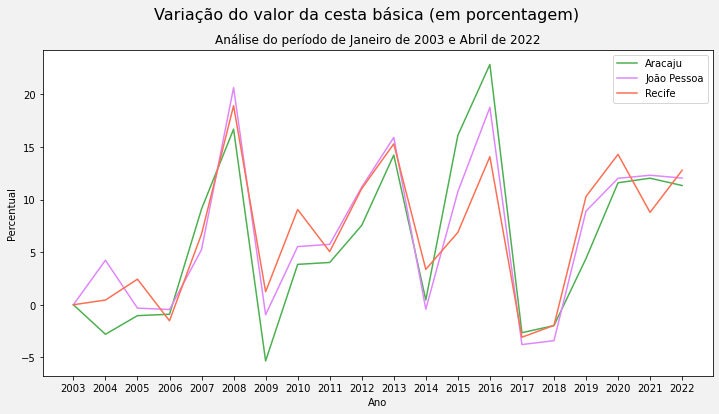

In [120]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
fig.patch.set_facecolor('#f2f2f2')
ax.set_facecolor('white')
plt.plot(df['perc_reaj_cb_aju'],c = '#4CAF50')
plt.plot(df['perc_reaj_cb_jpa'],c = '#E086FC')
plt.plot(df['perc_reaj_cb_rec'],c = '#FC6F53')
plt.legend(['Aracaju','João Pessoa','Recife'])
plt.xlabel('Ano')
plt.ylabel('Percentual')
plt.suptitle('Variação do valor da cesta básica (em porcentagem)', fontsize=16)
plt.title('Análise do período de Janeiro de 2003 e Abril de 2022', fontsize=12)

Text(0.5, 1.0, 'Análise do período de Janeiro de 2003 e Abril de 2022')

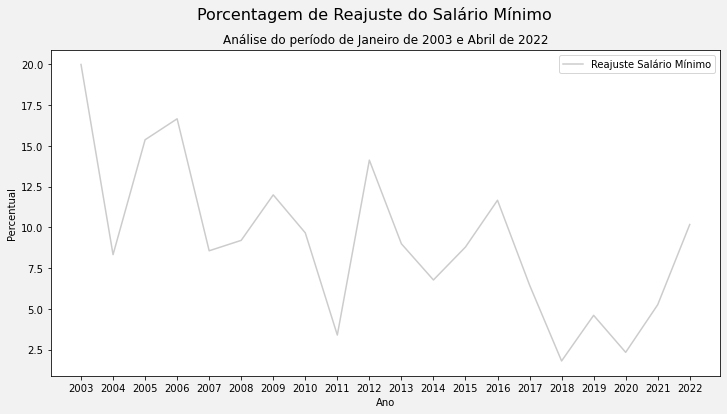

In [121]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
fig.patch.set_facecolor('#f2f2f2')
ax.set_facecolor('white')
plt.plot(df['vl_reaj_sm'], c = '#ccc')
plt.legend(['Reajuste Salário Mínimo'])
plt.xlabel('Ano')
plt.ylabel('Percentual')
plt.suptitle('Porcentagem de Reajuste do Salário Mínimo', fontsize=16)
plt.title('Análise do período de Janeiro de 2003 e Abril de 2022', fontsize=12)

Text(0.5, 1.0, 'Análise do período de Janeiro de 2003 e Abril de 2022')

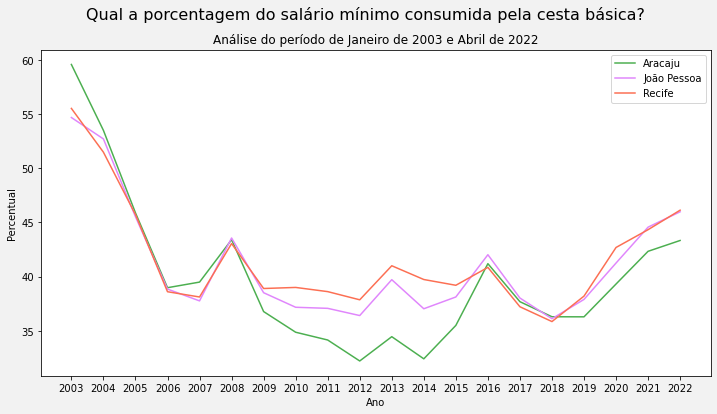

In [122]:
#fig = plt.subplots(figsize=(12,6))
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
fig.patch.set_facecolor('#f2f2f2')
ax.set_facecolor('white')
plt.plot(df['perc_sm_cb_aju'],c = '#4CAF50')
plt.plot(df['perc_sm_cb_jpa'],c = '#E086FC')
plt.plot(df['perc_sm_cb_rec'],c = '#FC6F53')
plt.legend(['Aracaju','João Pessoa','Recife'])
plt.xlabel('Ano')
plt.ylabel('Percentual')
plt.suptitle('Qual a porcentagem do salário mínimo consumida pela cesta básica?', fontsize=16)
plt.title('Análise do período de Janeiro de 2003 e Abril de 2022', fontsize=12)